In [6]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import tensorflow as tf

In [19]:
scalesize = 64
#this will get all the png images from all the folder types
path_to_train = "./plant-seedlings-classification/train/*/*.png"

#get all the images present
files = glob(path_to_train)

#now we create 2 lists, one to contain the images
#other to contain the images
train_images_ls = []
train_label_ls = []
num=1
max_size = len(files)

#loop over the file names to read and resize images
#collect the label names as well
for img in files:
  print(str(num)+"/"+str(max_size),end="\r")
  train_images_ls.append(cv2.resize(cv2.imread(img),(scalesize,scalesize)))
  train_label_ls.append(img.split('\\')[-2])
  num +=1
#converting training image list to a numpy array
train_images_ls = np.asarray(train_images_ls)

#converting the labels to pandas 
train_label_ls = pd.DataFrame(train_label_ls)

In [20]:
#summary of the training labels
train_label_ls.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

### Image Preprocessing

In [21]:
#defining helper functions

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

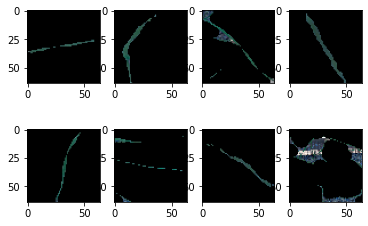

In [22]:
#now creating a new list with the corrected image
segmented_image_ls = []

for i in range(0,len(train_images_ls)):
    segmented_image_ls.append(sharpen_image(segment_plant(train_images_ls[i])))

segmented_image_ls = np.asarray(segmented_image_ls)
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_image_ls[i])

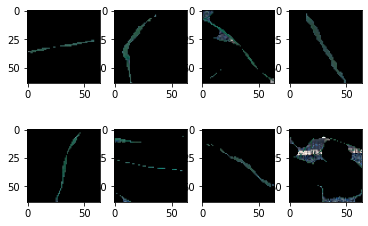

In [23]:
# Now we will normalize the images 
segmented_image_ls = segmented_image_ls/255

# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_image_ls[i])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


<AxesSubplot:>

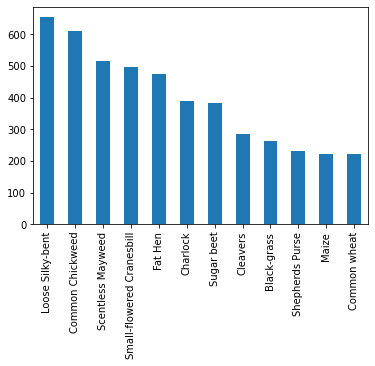

In [24]:
# Encode labels and create classes
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label_ls[0])
print("Classes: " + str(label_encoder.classes_))
encodeTrainLabels = label_encoder.transform(train_label_ls[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
train_label_ls[0].value_counts().plot(kind='bar')

In [32]:
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    ) 

### Model Building

In [39]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [35]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [36]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(12, activation='softmax'))

In [37]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 12)                6156      
                                                                 
Total params: 24,642,956
Trainable params: 1,055,244
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

n_split=5
accuracy_ls = []
for train_index,test_index in KFold(n_split,shuffle=True,random_state=7).split(segmented_image_ls):
        x_train,x_test=segmented_image_ls[train_index],segmented_image_ls[test_index]
        y_train,y_test=clearTrainLabel[train_index],clearTrainLabel[test_index]
        datagen.fit(x_train)
        model = resnet_model
        model_checkpoint = ModelCheckpoint('plantspecies_CNN_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=10, validation_data=(x_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])
        
        #score and accuracy of the model
        score, acc = model.evaluate(x_test,y_test)
        accuracy_ls.append(acc)
        print(accuracy_ls)
        print('Validation score:', score,'   Validation accuracy:', acc)
        tf.keras.backend.clear_session()
print()
print()
print()
print("Cross Validation Accuracy: ",sum(accuracy_ls)/5)

<ipython-input-38-e607b22c2f74>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=100),


Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 2.4348 - accuracy: 0.1516
Epoch 1: val_accuracy improved from -inf to 0.20211, saving model to plantspecies_CNN_model.h5
38/38 [==============================] - 24s 569ms/step - loss: 2.4348 - accuracy: 0.1516 - val_loss: 2.3777 - val_accuracy: 0.2021
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 2.3581 - accuracy: 0.1979
Epoch 2: val_accuracy did not improve from 0.20211
38/38 [==============================] - 25s 663ms/step - loss: 2.3581 - accuracy: 0.1979 - val_loss: 2.3390 - val_accuracy: 0.1821
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 2.3076 - accuracy: 0.2089
Epoch 3: val_accuracy did not improve from 0.20211
38/38 [==============================] - 26s 670ms/step - loss: 2.3076 - accuracy: 0.2089 - val_loss: 2.3166 - val_accuracy: 0.1737
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 2.2563 - accuracy: 0.2239
Epoch 4: val_accuracy improved 

Epoch 7/10
38/38 [==============================] - ETA: 0s - loss: 1.8730 - accuracy: 0.3487
Epoch 7: val_accuracy did not improve from 0.39684
38/38 [==============================] - 26s 675ms/step - loss: 1.8730 - accuracy: 0.3487 - val_loss: 1.8003 - val_accuracy: 0.3779
Epoch 8/10
38/38 [==============================] - ETA: 0s - loss: 1.8690 - accuracy: 0.3463
Epoch 8: val_accuracy did not improve from 0.39684
38/38 [==============================] - 27s 708ms/step - loss: 1.8690 - accuracy: 0.3463 - val_loss: 1.8542 - val_accuracy: 0.3579
Epoch 9/10
38/38 [==============================] - ETA: 0s - loss: 1.8647 - accuracy: 0.3463
Epoch 9: val_accuracy improved from 0.39684 to 0.41158, saving model to plantspecies_CNN_model.h5
38/38 [==============================] - 27s 716ms/step - loss: 1.8647 - accuracy: 0.3463 - val_loss: 1.7294 - val_accuracy: 0.4116
Epoch 10/10
38/38 [==============================] - ETA: 0s - loss: 1.8658 - accuracy: 0.3384
Epoch 10: val_accuracy did 

### Final Model Selection and evaluation

In [40]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(segmented_image_ls, clearTrainLabel, 
                                                test_size=0.1, random_state=7, 
                                                stratify = clearTrainLabel)
datagen.fit(trainX)

In [41]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(12, activation='softmax'))

resnet_model.compile(optimizer=K.optimizers.RMSprop(lr=2e-5),loss='categorical_crossentropy',metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [42]:
final_model = resnet_model
model_checkpoint = ModelCheckpoint('final_plantspecies_CNN_model.h5', #where to save the model
                                            save_best_only=True, 
                                            monitor='val_accuracy', 
                                            mode='max', 
                                            verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = final_model.fit_generator(datagen.flow(trainX, trainY, batch_size=100), 
            epochs=50, validation_data=(testX, testY),   
            callbacks = [early_stopping, model_checkpoint])

<ipython-input-42-eaff47bf51e4>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(datagen.flow(trainX, trainY, batch_size=32),


Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.4884 - accuracy: 0.1071
Epoch 1: val_accuracy improved from -inf to 0.13684, saving model to final_plantspecies_CNN_model.h5
134/134 [==============================] - 35s 237ms/step - loss: 2.4884 - accuracy: 0.1071 - val_loss: 2.4191 - val_accuracy: 0.1368
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 2.4120 - accuracy: 0.1462
Epoch 2: val_accuracy improved from 0.13684 to 0.19368, saving model to final_plantspecies_CNN_model.h5
134/134 [==============================] - 30s 226ms/step - loss: 2.4120 - accuracy: 0.1462 - val_loss: 2.4045 - val_accuracy: 0.1937
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 2.4056 - accuracy: 0.1759
Epoch 3: val_accuracy improved from 0.19368 to 0.20632, saving model to final_plantspecies_CNN_model.h5
134/134 [==============================] - 33s 243ms/step - loss: 2.4056 - accuracy: 0.1759 - val_loss: 2.3995 - val_accuracy: 0.2063
E

Epoch 29/50
134/134 [==============================] - ETA: 0s - loss: 2.3162 - accuracy: 0.2164
Epoch 29: val_accuracy did not improve from 0.21684
134/134 [==============================] - 29s 214ms/step - loss: 2.3162 - accuracy: 0.2164 - val_loss: 2.3051 - val_accuracy: 0.2063
Epoch 30/50
134/134 [==============================] - ETA: 0s - loss: 2.3129 - accuracy: 0.2211
Epoch 30: val_accuracy did not improve from 0.21684
134/134 [==============================] - 27s 204ms/step - loss: 2.3129 - accuracy: 0.2211 - val_loss: 2.3006 - val_accuracy: 0.2105
Epoch 31/50
134/134 [==============================] - ETA: 0s - loss: 2.3103 - accuracy: 0.2152
Epoch 31: val_accuracy did not improve from 0.21684
134/134 [==============================] - 29s 213ms/step - loss: 2.3103 - accuracy: 0.2152 - val_loss: 2.2966 - val_accuracy: 0.2042
Epoch 32/50
134/134 [==============================] - ETA: 0s - loss: 2.3094 - accuracy: 0.2119
Epoch 32: val_accuracy did not improve from 0.21684
13

15/15 [==============================] - 4s 164ms/step


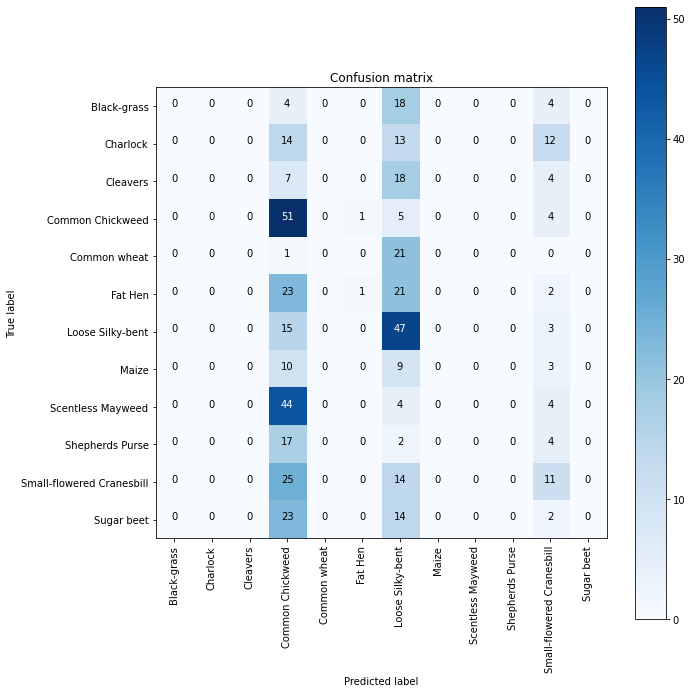

In [43]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = final_model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = label_encoder.classes_)

### Generating Test Output

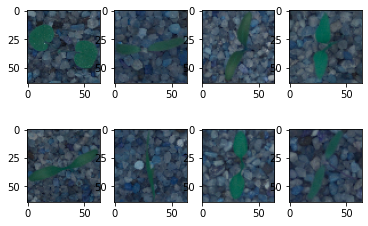

In [49]:
path = './plant-seedlings-classification/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('\\')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (scalesize, scalesize)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

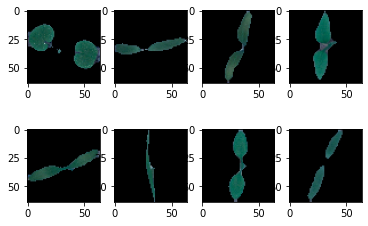

In [51]:
#now creating a new list with the corrected image
segmented_test_image_ls = []

for i in range(0,len(testImg)):
    segmented_test_image_ls.append(sharpen_image(segment_plant(testImg[i])))

segmented_test_image_ls = np.asarray(segmented_test_image_ls)
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(segmented_test_image_ls[i])

In [52]:
#Normalize
segmented_test_image_ls = segmented_test_image_ls / 255

In [53]:
pred = final_model.predict(segmented_test_image_ls)

25/25 [==============================] - 5s 186ms/step


In [54]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = label_encoder.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("submission.csv", index=False)